<a href="https://colab.research.google.com/github/divyagunde16/64061_AML/blob/main/Assignment2_G11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Downloading the data

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gundedivya1696","key":"7b1a8c70690bee411f393df3ec878ec3"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c dogs-vs-cats

100% 810M/812M [00:36<00:00, 19.4MB/s]
100% 812M/812M [00:36<00:00, 23.4MB/s]


In [ ]:
!unzip -qq dogs-vs-cats.zip

In [ ]:
!unzip -qq train.zip

#Transferring pictures to test, validation, and training folders and intially considering 1000 for train, 500 for test and 500 for validation

In [ ]:
import os
import shutil
from pathlib import Path

original_dir = Path("train")
new_base_dir = Path("cats_vs_dogs_small_1000")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        subset_dir = new_base_dir / subset_name / category
        os.makedirs(subset_dir, exist_ok=True)  # Create the directory if it doesn't exist
        file_names = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for file_name in file_names:
            source_path = original_dir / file_name
            destination_path = subset_dir / file_name
            shutil.copyfile(src=source_path, dst=destination_path)

# Define the ranges for each subset
subset_ranges = {
    "train": (0, 1000),
    "validation": (1000, 1500),
    "test": (1500, 2000)
}

# Generate the subsets
for subset_name, (start, end) in subset_ranges.items():
    make_subset(subset_name, start, end)


### Building the model

**Instantiating a small convnet for dogs vs. cats classification**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# Define the input shape
input_shape = (180, 180, 3)
inputs = keras.Input(shape=input_shape)

# Data preprocessing: Rescale the input values to the range [0, 1]
x = layers.Rescaling(1./255)(inputs)

# Define the convolutional layers
conv_filters = [32, 64, 128, 256, 256]
for filters in conv_filters:
    x = layers.Conv2D(filters=filters, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

# Flatten the output for fully connected layers
x = layers.Flatten()(x)

# Define the output layer with sigmoid activation for binary classification
outputs = layers.Dense(1, activation="sigmoid")(x)

# Create the model
model = keras.Model(inputs=inputs, outputs=outputs)


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                        

**Configuring the model for training**

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

### Data preprocessing

#Training = 1000; Validation = 500; Test = 500

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [ ]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [ ]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [ ]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


#Displaying the shapes of the data and labels yielded by the Dataset

In [ ]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


#Fitting the model using a Dataset

In [ ]:
from tensorflow import keras

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.x",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=callbacks
)


Epoch 1/20
63/63 [==============================] - 11s 81ms/step - loss: 0.6929 - accuracy: 0.5130 - val_loss: 0.6867 - val_accuracy: 0.5140
Epoch 2/20
63/63 [==============================] - 4s 59ms/step - loss: 0.6838 - accuracy: 0.5610 - val_loss: 0.6723 - val_accuracy: 0.5850
Epoch 3/20
63/63 [==============================] - 4s 56ms/step - loss: 0.6560 - accuracy: 0.6270 - val_loss: 0.6574 - val_accuracy: 0.5970
Epoch 4/20
63/63 [==============================] - 4s 57ms/step - loss: 0.6270 - accuracy: 0.6540 - val_loss: 0.6272 - val_accuracy: 0.6450
Epoch 5/20
63/63 [==============================] - 4s 56ms/step - loss: 0.5899 - accuracy: 0.6940 - val_loss: 0.6110 - val_accuracy: 0.6730
Epoch 6/20
63/63 [==============================] - 3s 39ms/step - loss: 0.5523 - accuracy: 0.7155 - val_loss: 0.6382 - val_accuracy: 0.6490
Epoch 7/20
63/63 [==============================] - 4s 55ms/step - loss: 0.5080 - accuracy: 0.7550 - val_loss: 0.5907 - val_accuracy: 0.6980
Epoch 8/20
6

#Displaying curves of loss and accuracy during training

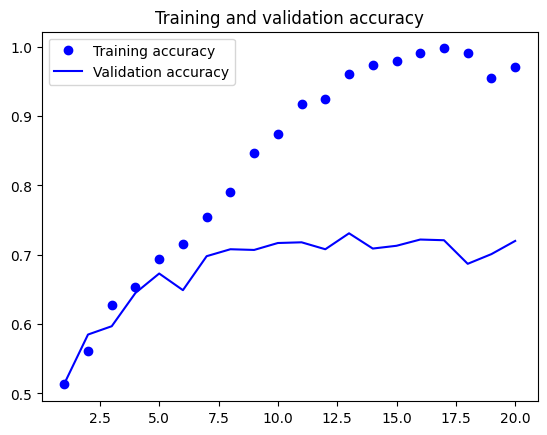

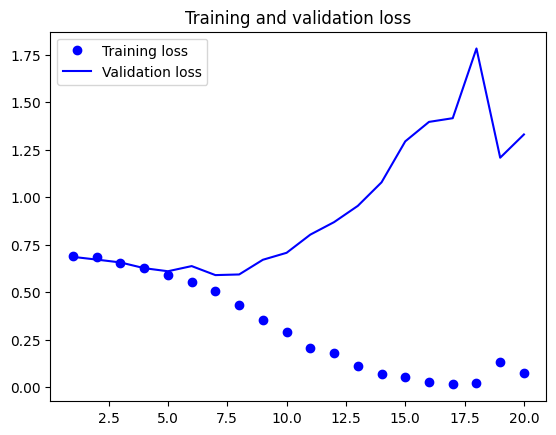

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#Evaluating the model on the test set

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 15ms/step - loss: 0.6285 - accuracy: 0.6980
Test accuracy: 0.698


#Transferring pictures to test, validation, and training folders and intially considering 2000 for train, 500 for test and 500 for validation

In [ ]:
import os
import shutil
from pathlib import Path

original_dir = Path("train")
new_base_dir = Path("cats_vs_dogs_small_2000")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        subset_dir = new_base_dir / subset_name / category
        os.makedirs(subset_dir, exist_ok=True)  # Create the directory if it doesn't exist
        file_names = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for file_name in file_names:
            source_path = original_dir / file_name
            destination_path = subset_dir / file_name
            shutil.copyfile(src=source_path, dst=destination_path)

# Define the ranges for each subset
subset_ranges = {
    "train": (0, 2000),
    "validation": (2000, 2500),
    "test": (2500, 3000)
}

# Generate the subsets
for subset_name, (start, end) in subset_ranges.items():
    make_subset(subset_name, start, end)


### Building the model

**Instantiating a small convnet for dogs vs. cats classification**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# Define the input shape
input_shape = (180, 180, 3)
inputs = keras.Input(shape=input_shape)

# Data preprocessing: Rescale the input values to the range [0, 1]
x = layers.Rescaling(1./255)(inputs)

# Define the convolutional layers
conv_filters = [32, 64, 128, 256, 256]
for filters in conv_filters:
    x = layers.Conv2D(filters=filters, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

# Flatten the output for fully connected layers
x = layers.Flatten()(x)

# Define the output layer with sigmoid activation for binary classification
outputs = layers.Dense(1, activation="sigmoid")(x)

# Create the model
model = keras.Model(inputs=inputs, outputs=outputs)


In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                      

**Configuring the model for training**

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

### Data preprocessing

#Training = 2000; Validation = 500; Test = 500

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 4000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [ ]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [ ]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [ ]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


**Displaying the shapes of the data and labels yielded by the `Dataset`**

In [ ]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


**Fitting the model using a Dataset**

In [ ]:
from tensorflow import keras

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.x",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks
)


Epoch 1/10
125/125 [==============================] - 8s 47ms/step - loss: 0.6972 - accuracy: 0.5048 - val_loss: 0.6929 - val_accuracy: 0.5050
Epoch 2/10
125/125 [==============================] - 6s 45ms/step - loss: 0.6866 - accuracy: 0.5487 - val_loss: 0.6559 - val_accuracy: 0.6190
Epoch 3/10
125/125 [==============================] - 5s 37ms/step - loss: 0.6523 - accuracy: 0.6135 - val_loss: 0.6840 - val_accuracy: 0.5530
Epoch 4/10
125/125 [==============================] - 6s 47ms/step - loss: 0.6219 - accuracy: 0.6525 - val_loss: 0.5664 - val_accuracy: 0.7160
Epoch 5/10
125/125 [==============================] - 6s 44ms/step - loss: 0.5639 - accuracy: 0.7005 - val_loss: 0.5559 - val_accuracy: 0.7240
Epoch 6/10
125/125 [==============================] - 6s 45ms/step - loss: 0.5305 - accuracy: 0.7337 - val_loss: 0.5338 - val_accuracy: 0.7420
Epoch 7/10
125/125 [==============================] - 6s 45ms/step - loss: 0.4729 - accuracy: 0.7755 - val_loss: 0.5147 - val_accuracy: 0.7670

**Displaying curves of loss and accuracy during training**

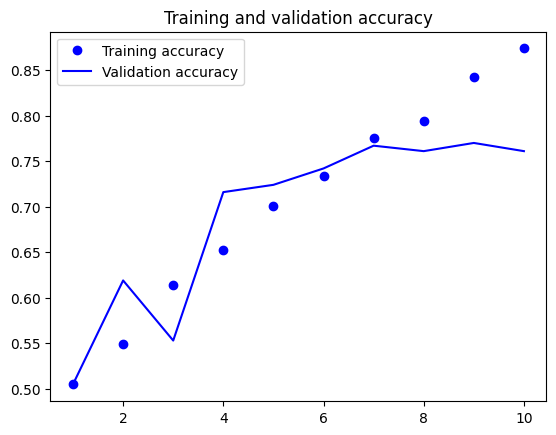

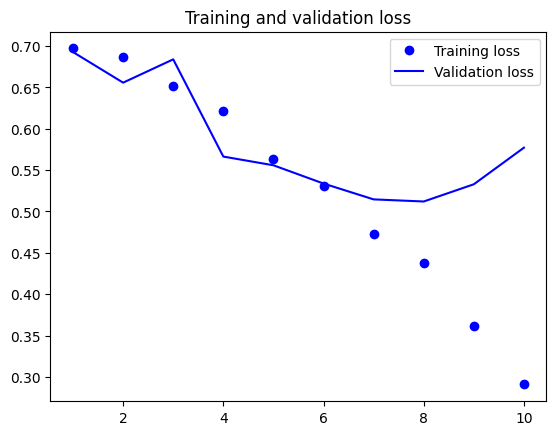

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Evaluating the model on the test set**

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 15ms/step - loss: 0.5550 - accuracy: 0.7430
Test accuracy: 0.743


#Transferring pictures to test, validation, and training folders and intially considering 3000 for train, 500 for test and 500 for validation

In [ ]:
import os
import shutil
from pathlib import Path

original_dir = Path("train")
new_base_dir = Path("cats_vs_dogs_small_3000")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        subset_dir = new_base_dir / subset_name / category
        os.makedirs(subset_dir, exist_ok=True)  # Create the directory if it doesn't exist
        file_names = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for file_name in file_names:
            source_path = original_dir / file_name
            destination_path = subset_dir / file_name
            shutil.copyfile(src=source_path, dst=destination_path)

# Define the ranges for each subset
subset_ranges = {
    "train": (0, 3000),
    "validation": (3000, 3500),
    "test": (3500, 4000)
}

# Generate the subsets
for subset_name, (start, end) in subset_ranges.items():
    make_subset(subset_name, start, end)


### Building the model

**Instantiating a small convnet for dogs vs. cats classification**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# Define the input shape
input_shape = (180, 180, 3)
inputs = keras.Input(shape=input_shape)

# Data preprocessing: Rescale the input values to the range [0, 1]
x = layers.Rescaling(1./255)(inputs)

# Define the convolutional layers
conv_filters = [32, 64, 128, 256, 256]
for filters in conv_filters:
    x = layers.Conv2D(filters=filters, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

# Flatten the output for fully connected layers
x = layers.Flatten()(x)

# Define the output layer with sigmoid activation for binary classification
outputs = layers.Dense(1, activation="sigmoid")(x)

# Create the model
model = keras.Model(inputs=inputs, outputs=outputs)


In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 43, 43, 64)        0         
 ng2D)                                                     

**Configuring the model for training**

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

### Data preprocessing

#Training = 3000; Validation = 500; Test = 500

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 6000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [ ]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [ ]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [ ]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


**Displaying the shapes of the data and labels yielded by the `Dataset`**

In [ ]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [ ]:
#model.compile(optimizer='adam', loss='mean_squared_error')


**Fitting the model using a `Dataset`**

In [ ]:
from tensorflow import keras

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.x",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks
)


Epoch 1/10
188/188 [==============================] - 10s 42ms/step - loss: 0.2420 - val_loss: 0.2263
Epoch 2/10
188/188 [==============================] - 8s 41ms/step - loss: 0.2180 - val_loss: 0.1856
Epoch 3/10
188/188 [==============================] - 8s 41ms/step - loss: 0.1927 - val_loss: 0.1712
Epoch 4/10
188/188 [==============================] - 8s 40ms/step - loss: 0.1690 - val_loss: 0.1607
Epoch 5/10
188/188 [==============================] - 8s 42ms/step - loss: 0.1476 - val_loss: 0.1584
Epoch 6/10
188/188 [==============================] - 8s 41ms/step - loss: 0.1316 - val_loss: 0.1509
Epoch 7/10
188/188 [==============================] - 8s 41ms/step - loss: 0.1094 - val_loss: 0.1429
Epoch 8/10
188/188 [==============================] - 8s 40ms/step - loss: 0.0935 - val_loss: 0.1374
Epoch 9/10
188/188 [==============================] - 7s 35ms/step - loss: 0.0802 - val_loss: 0.1414
Epoch 10/10
188/188 [==============================] - 8s 40ms/step - loss: 0.0620 - val_l

# Evaluating the model on the test set

# **Using data augmentation**

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

# Showing some randomly enhanced training pictures

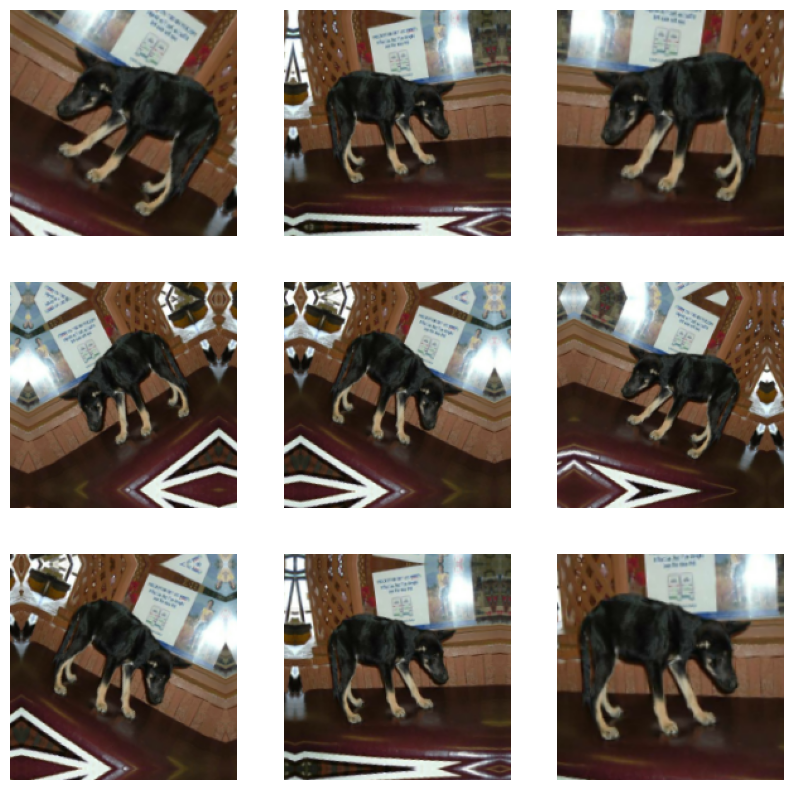

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# **Defining a new convnet that includes image augmentation and dropout**

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

# **Training the regularized convnet**

In [ ]:
#Have run with data augmentation for training set of 1000,2000 and 3000
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.x",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
188/188 [==============================] - 13s 51ms/step - loss: 0.6937 - accuracy: 0.5067 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/10
188/188 [==============================] - 9s 46ms/step - loss: 0.6927 - accuracy: 0.5123 - val_loss: 0.6920 - val_accuracy: 0.5010
Epoch 3/10
188/188 [==============================] - 9s 47ms/step - loss: 0.6886 - accuracy: 0.5517 - val_loss: 0.6721 - val_accuracy: 0.5910
Epoch 4/10
188/188 [==============================] - 7s 37ms/step - loss: 0.6858 - accuracy: 0.5455 - val_loss: 0.6789 - val_accuracy: 0.5690
Epoch 5/10
188/188 [==============================] - 9s 48ms/step - loss: 0.6633 - accuracy: 0.6013 - val_loss: 0.6445 - val_accuracy: 0.6410
Epoch 6/10
188/188 [==============================] - 9s 47ms/step - loss: 0.6412 - accuracy: 0.6310 - val_loss: 0.6162 - val_accuracy: 0.6550
Epoch 7/10
188/188 [==============================] - 9s 46ms/step - loss: 0.6193 - accuracy: 0.6652 - val_loss: 0.5807 - val_accuracy: 0.691

# **Evaluating the model on the test set**

In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 15ms/step - loss: 0.5275 - accuracy: 0.7540
Test accuracy: 0.754


# Using a pretrained model


In [ ]:
import keras
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

# Feature extraction without data augmentation

In [ ]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 19ms/step


#Defining and training the classifier

In [ ]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.x",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=10,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/10
188/188 [==============================] - 2s 9ms/step - loss: 7.4224 - accuracy: 0.9540 - val_loss: 3.7398 - val_accuracy: 0.9780
Epoch 2/10
188/188 [==============================] - 1s 7ms/step - loss: 2.4584 - accuracy: 0.9822 - val_loss: 3.6947 - val_accuracy: 0.9790
Epoch 3/10
188/188 [==============================] - 1s 7ms/step - loss: 1.5321 - accuracy: 0.9877 - val_loss: 3.2860 - val_accuracy: 0.9790
Epoch 4/10
188/188 [==============================] - 1s 4ms/step - loss: 0.6198 - accuracy: 0.9938 - val_loss: 3.5662 - val_accuracy: 0.9850
Epoch 5/10
188/188 [==============================] - 1s 4ms/step - loss: 0.7777 - accuracy: 0.9938 - val_loss: 4.1808 - val_accuracy: 0.9790
Epoch 6/10
188/188 [==============================] - 1s 4ms/step - loss: 0.5280 - accuracy: 0.9950 - val_loss: 5.2817 - val_accuracy: 0.9820
Epoch 7/10
188/188 [==============================] - 1s 4ms/step - loss: 0.2947 - accuracy: 0.9968 - val_loss: 4.6159 - val_accuracy: 0.9840
Epoch 

# Graphical representation

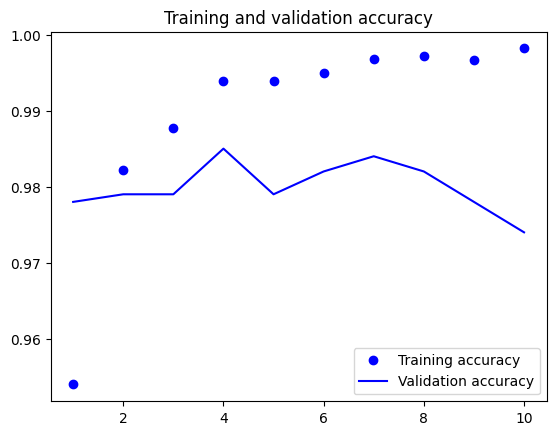

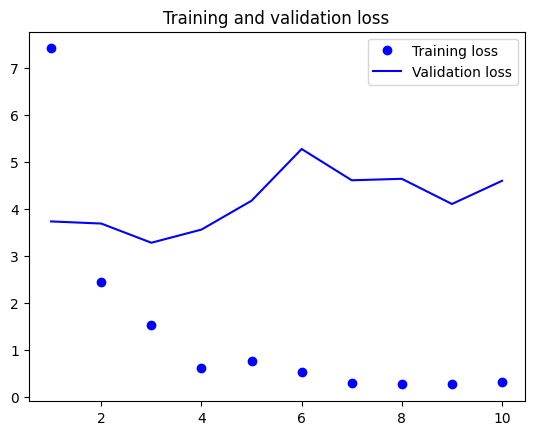

In [ ]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_features, test_labels)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Changing optimizer to rmsprop

In [ ]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.x",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=10,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/10
188/188 [==============================] - 2s 7ms/step - loss: 10.0271 - accuracy: 0.9495 - val_loss: 5.5398 - val_accuracy: 0.9620
Epoch 2/10
188/188 [==============================] - 1s 4ms/step - loss: 3.8545 - accuracy: 0.9785 - val_loss: 5.8642 - val_accuracy: 0.9660
Epoch 3/10
188/188 [==============================] - 1s 6ms/step - loss: 2.0030 - accuracy: 0.9860 - val_loss: 4.9516 - val_accuracy: 0.9750
Epoch 4/10
188/188 [==============================] - 2s 9ms/step - loss: 1.4952 - accuracy: 0.9883 - val_loss: 4.4636 - val_accuracy: 0.9740
Epoch 5/10
188/188 [==============================] - 1s 6ms/step - loss: 0.8684 - accuracy: 0.9935 - val_loss: 3.4835 - val_accuracy: 0.9780
Epoch 6/10
188/188 [==============================] - 1s 4ms/step - loss: 0.6521 - accuracy: 0.9935 - val_loss: 4.4706 - val_accuracy: 0.9760
Epoch 7/10
188/188 [==============================] - 1s 4ms/step - loss: 0.4102 - accuracy: 0.9963 - val_loss: 4.4603 - val_accuracy: 0.9750
Epoch

In [ ]:
test_loss, test_accuracy = model.evaluate(test_features, test_labels)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

32/32 [==============================] - 0s 2ms/step - loss: 5.3790 - accuracy: 0.9750
Test Loss: 5.378988265991211
Test Accuracy: 0.9750000238418579


# Feature extraction together with data augmentation

In [ ]:
import keras
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

# Printing the trainable weights list both before and after the freezer

In [ ]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [ ]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


# incorporating a classifier and a data augmentation stage into the convolutional base

In [ ]:
from tensorflow.keras import layers
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.x",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)


Epoch 1/10
188/188 [==============================] - 24s 119ms/step - loss: 8.2635 - accuracy: 0.9295 - val_loss: 3.6843 - val_accuracy: 0.9720
Epoch 2/10
188/188 [==============================] - 23s 123ms/step - loss: 5.6703 - accuracy: 0.9498 - val_loss: 2.7550 - val_accuracy: 0.9760
Epoch 3/10
188/188 [==============================] - 23s 124ms/step - loss: 3.9085 - accuracy: 0.9595 - val_loss: 2.5239 - val_accuracy: 0.9740
Epoch 4/10
188/188 [==============================] - 23s 119ms/step - loss: 2.4482 - accuracy: 0.9690 - val_loss: 2.5032 - val_accuracy: 0.9720
Epoch 5/10
188/188 [==============================] - 23s 124ms/step - loss: 1.4236 - accuracy: 0.9692 - val_loss: 0.9552 - val_accuracy: 0.9790
Epoch 6/10
188/188 [==============================] - 23s 121ms/step - loss: 0.9414 - accuracy: 0.9698 - val_loss: 0.8137 - val_accuracy: 0.9720
Epoch 7/10
188/188 [==============================] - 23s 120ms/step - loss: 0.4704 - accuracy: 0.9738 - val_loss: 0.6569 - val_ac

# Graphical representation

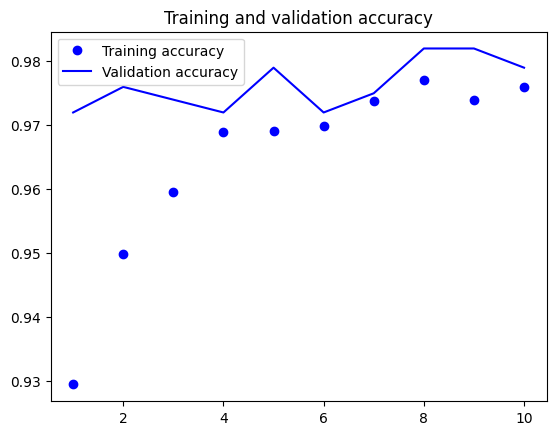

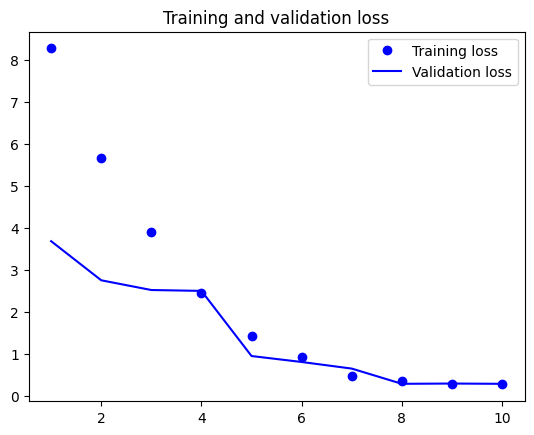

In [ ]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

# Evaluating the model on the test set

In [ ]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 3s 84ms/step - loss: 0.5324 - accuracy: 0.9800
Test accuracy: 0.980


In [ ]:
from tensorflow.keras import layers
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.x",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)


Epoch 1/10
188/188 [==============================] - 24s 122ms/step - loss: 12.1163 - accuracy: 0.9232 - val_loss: 7.4754 - val_accuracy: 0.9480
Epoch 2/10
188/188 [==============================] - 23s 121ms/step - loss: 6.2726 - accuracy: 0.9510 - val_loss: 3.2898 - val_accuracy: 0.9790
Epoch 3/10
188/188 [==============================] - 23s 122ms/step - loss: 5.0735 - accuracy: 0.9577 - val_loss: 2.1271 - val_accuracy: 0.9750
Epoch 4/10
188/188 [==============================] - 23s 120ms/step - loss: 3.2017 - accuracy: 0.9602 - val_loss: 1.5433 - val_accuracy: 0.9790
Epoch 5/10
188/188 [==============================] - 23s 120ms/step - loss: 2.2442 - accuracy: 0.9660 - val_loss: 1.5099 - val_accuracy: 0.9790
Epoch 6/10
188/188 [==============================] - 23s 122ms/step - loss: 1.4915 - accuracy: 0.9675 - val_loss: 0.7668 - val_accuracy: 0.9830
Epoch 7/10
188/188 [==============================] - 23s 120ms/step - loss: 1.2609 - accuracy: 0.9645 - val_loss: 0.6975 - val_a

#Evaluating model on test set

In [ ]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 3s 85ms/step - loss: 0.6740 - accuracy: 0.9770
Test accuracy: 0.977
